## Discovering transcription factor binding motifs and binding sites in promoter sequences

As we discussed in the introduction session, transcription of DNA into RNA is carried out by the RNA polymerase, which is recruited to the DNA by transcription factors (TFs), proteins that bind specific sequence elements in the DNA. We typically describe the sequence specificity of transcription factors by position-specific weight matrices (PWMs), giving the probabilities of finding each of the four nucleotides at each position of binding sites. Let's see how we can use the HMM framework to describe promoter sequences, find binding sites and infer the PWM of a transcription factor from sequences that contain such binding sites.

### Block 1. Generating synthetic sequence data

Testing with ground truth data is crucial when we develop code. Ground truth biological data is often difficult to obtain, as even the measurement processes are complex, with hard to identify and characterize biases. That is why synthetic data is important: it allows us to determine whether our code works correctly within the assumptions of the model underlying the code. Of course, this does not mean that real data obeys these assumptions, which is why showing that the code works on synthetic data doesn't mean that we have a good tool to analyze real data. Nevertheless, the correctness of the implementation is the first step that we always need to check. So let's generate ourselves a ground truth dataset of "promoter sequences" containing binding sites for a transcription factor.

1. Generate a PWM of your liking
- typical length for eukaryotic TF binding sites is 6-8 nucleotides
- play around with the **bias** of your PWM, i.e. the sequence that has the highest probability under the PWM model
- make sure to write functions that:
    - calculate the information content of the PWM (we'll look into this in a future session)
    - *sample* a binding site from this PWM in proportion to its probability
2. Generate random promoter sequences your chosen A,C,G,T composition.
3. Introduce binding sites sampled from the PWM in the promoter sequences. Keep track of this information to be able to check it later.
4. Check if motif finding software (e.g. MEME, we'll talk about it later as well) recovers the motif you places in your sequence.

### Block 2. Predicting binding sites for TFs with known sequence specificity

1. Implement the forward/backward algorithms. Can you run them on your sequences?
2. Adapt your code to calculate instead ratios of sequence likelihoods (as described in https://cdn.aaai.org/ISMB/2000/ISMB00-007.pdf).
2. Use the functions you implemented to evaluate the posterior probability of binding sites along the promoter sequences you created.
3. Compare your results with your ground truth data.

### Block 3. Training the HMM

Now let's see if we can use the tools we got to actually infer the specificity of the TF from the synthetic data that you generated.

1. Implement the Baum-Welch algorithm to infer the PWM and the transition probability between random sequence and binding sites in promoter sequences (assuming an HMM with 4 states: Start, Random, BindingSite, End).
2. Does it inferred PWM match the one you picked the beginning?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seqlogo
# from IPython.display import display, Markdown
from jupyprint import jupyprint, arraytex
from tabulate import tabulate
import arraytex as atx
import graphviz
from pymemesuite.common import Sequence
# from pymemesuite.fimo import FIMO

#### Block 1 Synthetic Transcription Factor Sequence
Information content of a given position weight matrix calculated by $I=\sum_{i,b}f_b^i\log\left(\frac{f_b^i}{p_b}\right)$ where $f_b^i$ is the frequency of the nucleotide in the position weight matrix and $p_b$ is the background frequency. 

In [ ]:
# Generate a random Position probability Matrix based on Dirichlet distribution
def get_random_pwm(tf_length, alpha=np.array([0.1, 0.1, 0.7, 0.1])):
    # This optimally should use a very heavily weighted alpha, gamma << 1
    # for each nucleotide as with balanced alpha information content is very low
    # Dirichlet is generalization of Beta distribution, codomain is [0,1]    
    ppm = []
    for _ in range(0, tf_length):
        np.random.shuffle(alpha)
        ppm.append(np.random.dirichlet(alpha))

    ppm = np.array(ppm).T
    # change dim of composition bias to match counts
    pseudocounts = alpha[:, np.newaxis]
    pwm = ppm + pseudocounts
    pwm = pwm / np.sum(pwm, axis=0)
    return pwm, ppm

In [3]:
def get_pwm_information_content(pwm, composition_bias):
    """ Calculate information content from pwm """
    bckg_freq = composition_bias[:, np.newaxis]
    ic = np.sum( pwm * np.log2(pwm / bckg_freq), axis=None)
    return ic

def sample_binding_site_from_pwm(pwm, num_samples, dna_letters='ACGT'):
    """ Sample Binding sites from a PWM """
    num_positions = pwm.shape[1]
    # store the sampled sequences
    sampled_sequences = []
    for _ in range(num_samples):
        # For each position, sample a letter based on the PWM probabilities
        sampled_sequence = ''.join(np.random.choice(dna_letters, p=pwm[:, i]) for i in range(num_positions))
        sampled_sequences.append(sampled_sequence)
    return sampled_sequences

def calculate_sequence_probability(pwm, sampled_sequences, dna_letters=['A', 'C', 'G', 'T'] ):
    """ Calculate the probabilities of the sampled sequences given a PWM """
    sampled_probs = []
    for seq in sampled_sequences:
        prob = 1.0
        for i, letter in enumerate(seq):
            prob *= pwm[dna_letters.index(letter), i]
        sampled_probs.append(prob)
    return zip(sampled_sequences, sampled_probs)

In [4]:
# Define dna letters for easier access
dna_letters = ['A', 'C', 'G', 'T']  # just char doesn't work with the nice-printing or .index
dna_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

# Define an assumed background composition bias for the sequence
bckg_composition_bias = np.ones(len(dna_letters))*0.25
# bckg_composition_bias = np.array([0.1, 0.4, 0.4, 0.1]) # CG Heavy
# bckg_composition_bias = np.array([0.4, 0.1, 0.1, 0.4]) # AT Heavy

# Randomly select a TF length between 6 and 8
tf_length = np.random.randint(6, 9)
# tf_length = 6  # testing

# Manual for testing: Define a PWM, too low of a bias will give low information content
# we'll remove columns to match the length of the TF then shuffle to get a different most likely TF
# pwm_raw = ([[0.11, 0.2,  0.03, 0.66], # 1
#             [0.11, 0.02, 0.02, 0.85], # 2
#             [0.02, 0.11, 0.66, 0.21], # 3
#             [0.75, 0.02, 0.02, 0.21], # 4
#             [0.02, 0.94, 0.02, 0.02], # 5
#             [0.57, 0.02, 0.11, 0.3],  # 6
#             [0.75, 0.11, 0.02, 0.02], # 7
#             [0.02, 0.11, 0.66, 0.21]  # 8
#             ])  

# # Manual: Randomly shuffle the PWM to get a different most likely TF
# np.random.shuffle(pwm_raw)

# # Manual: Cut the Manual PWM to the length of the TF
# max_length_pwm = 8
# del pwm_raw[tf_length-max_length_pwm:]

# Convert the PWM to a array
# pwm = np.array(pwm_raw).T

# Alternative: Get random PWM from biased dirichlet distribution
# [0.1, 0.1, 0.7, 0.1] is a good alpha for a random PWM for high ic
pwm, ppm = get_random_pwm(tf_length, alpha=np.array([0.1, 0.1, 0.7, 0.1]))

# Convert to df just for nice printing below
pwm_df = pd.DataFrame(pwm, index=dna_letters, columns=range(tf_length))
print(f"\nTF of length {tf_length} Position Weight Matrix:\n{tabulate(pwm_df, headers='keys', tablefmt='psql', showindex=True)}")

# Calculate information content of pwm using often gives too low information content to be useful
ic = get_pwm_information_content(pwm, bckg_composition_bias)
print(f"\nInformation content of the PWM: {ic:0.3f} bits")

# Print most likely sequence from pwm
most_probable_tf_binding_site = ''.join([dna_letters[np.argmax(pwm[:, i])] for i in range(tf_length)])
most_probable_tf_probability = calculate_sequence_probability(pwm, [most_probable_tf_binding_site], dna_letters)
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site} with probability {list(most_probable_tf_probability)[0][1]:0.4f}")



TF of length 7 Position Weight Matrix:
+----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|    |         0 |         1 |         2 |         3 |         4 |         5 |         6 |
|----+-----------+-----------+-----------+-----------+-----------+-----------+-----------|
| A  | 0.0500068 | 0.545358  | 0.0558394 | 0.362307  | 0.0500431 | 0.05      | 0.144698  |
| C  | 0.547989  | 0.05      | 0.0585183 | 0.0552961 | 0.331196  | 0.0500265 | 0.05      |
| G  | 0.352005  | 0.35      | 0.835642  | 0.504972  | 0.50196   | 0.849966  | 0.730998  |
| T  | 0.05      | 0.0546424 | 0.05      | 0.0774247 | 0.116801  | 0.0500078 | 0.0743042 |
+----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+

Information content of the PWM: 4.978 bits

Most probable TF binding site sequence: CAGGGGG with probability 0.0393


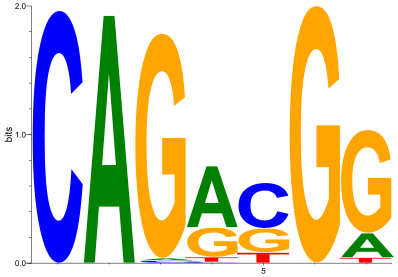

In [5]:
ppm_fig = seqlogo.Ppm(ppm)
seqlogo.seqlogo(ppm_fig, font_size=30, ic_scale=True, format='svg') # attach to axis not working

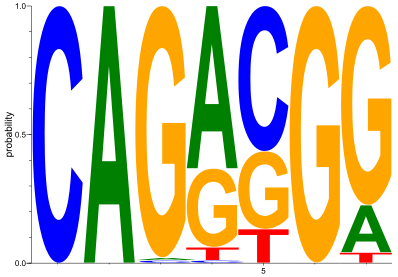

In [6]:
ppm_fig = seqlogo.Ppm(ppm)
seqlogo.seqlogo(ppm_fig, font_size=30, ic_scale=False, format='svg') 

In [7]:
# sample binding sites and print their associated probabilities
num_samples = 1

# sample binding sites from the pwm
sampled_sequences = sample_binding_site_from_pwm(pwm, num_samples, dna_letters)

# Testing: get most probable --> ensure this matches above num_samples!!
# sampled_sequences = [most_probable_tf_binding_site]  

# Calculate the probabilities of the sampled sequences
sampled_probs = calculate_sequence_probability(pwm, sampled_sequences, dna_letters)
print("\nSampled sequences and their probabilities:")
for seq, prob in sampled_probs:
    print(f"Sequence: {seq}, Probability: {prob:.6f}")


Sampled sequences and their probabilities:
Sequence: CAGGGGA, Probability: 0.007785


In [8]:
# Cleanup workspace
# del max_length_pwm, pwm_raw, pwm_df, ppm_fig

In [9]:
def create_random_sequence_with_sampled_sites(length, composition_bias, sampled_sequences):
    # Generate a random sequence with the given length and background composition bias
    random_sequence = ''.join(np.random.choice(dna_letters, size=length, p=composition_bias))

    tf_positions = []
    
    # Randomly select positions to insert the sampled sequences
    # no validation of positions, so may overlap
    for seq in sampled_sequences:
        pos = np.random.randint(0, length - len(seq) + 1)
        tf_positions.append(pos)
        random_sequence = random_sequence[:pos] + seq + random_sequence[pos + len(seq):]
    
    return random_sequence, tf_positions

In [10]:
# Create and print random sequence with sampled sites
sequence_length = 200

random_sequence, tf_positions = create_random_sequence_with_sampled_sites(sequence_length, bckg_composition_bias, sampled_sequences)

jupyprint(f"\nRandom sequence of length {sequence_length} with background composition bias {bckg_composition_bias}:")
jupyprint(f"Random sequence with sampled binding sites: {random_sequence}")
jupyprint(f"Sampled binding sites inserted at positions: {tf_positions}")


Random sequence of length 200 with background composition bias [0.25 0.25 0.25 0.25]:

Random sequence with sampled binding sites: ATCCATGTTTGTAGTTGGGAATACCCTCAAGCCTGCTGCGTGATTTCTTGGAAACGGACATGCTACTTTCTCAGCGGACCCATTGTTTCTAATTGACACCGCCTCCCCCGCCAGCCCAACCCAGAACAGGGGAAGTACGCGGGGATTGCGGGTACAACTCTGCACTGAGAGGCAATCCACCGAGAACGACACTGTTTAGA

Sampled binding sites inserted at positions: [126]

In [11]:
# Sanity Check Manually search string for the sampled binding sites with regex
import re
def find_binding_sites_in_sequence(sequence, binding_sites):
    found_positions = {}
    for site in binding_sites:
        positions = [m.start() for m in re.finditer(site, sequence)]
        if positions:
            found_positions[site] = positions
        else:
            raise ValueError(f"Binding site {site} not found in the sequence!!?!?!")
    return found_positions
# Find binding sites in the random sequence
found_positions = find_binding_sites_in_sequence(random_sequence, sampled_sequences)
print(f"\nSanity Check binding site in the random sequence:\n{found_positions}")



Sanity Check binding site in the random sequence:
{'CAGGGGA': [126]}


Check the log-likelihood of the sequence given the background composition
$L(s|\vec{x})=\sum_in_i\ \text{log}_2(\pi_i)$ just to make sure our random sequence didn't end up too biased

In [12]:
counts = np.zeros((len(dna_letters),), dtype=int)
# There's probably a nice regex to do this but this is easy
for letter in random_sequence:
    counts[dna_dict[letter]] += 1
# Convert counts to log-likelihood
EL_s = np.sum(counts * np.log2(bckg_composition_bias))
L_s = np.sum(counts * np.log2(np.array(counts, dtype="float")/len(random_sequence)))
# P_s = 1 # Sanity Check probability and to see what 2^-400 is (3e-121)
# for count in counts:
#     P_s *= np.power(0.25,count)
# print($"Expected Likelihood of sequence given background composition{P_s}")
print(f"\nLog-Likelihood of the random sequence length {sum(counts)} (independence assumption): {L_s:.2f}"+
      f" Expected: {EL_s}")


Log-Likelihood of the random sequence length 200 (independence assumption): -398.92 Expected: -400.0


#### Block 2 Inferring TF Binding Site with Forward-Backward Algorithm
NOTE: this needs to be rewritten the simple 4-state hmm (start, bindingsite, background, end)

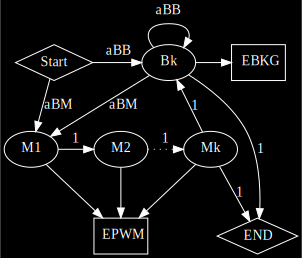

In [13]:
# Make nice visualization of HMM
dot = graphviz.Digraph(comment='HMM', format='svg')

dot.attr(rankdir='TD')
dot.attr(bgcolor='black')
dot.attr('edge', color='white',fontcolor='white')
dot.attr('node', style='filled',fillcolor='black', fontcolor='white', color='white')

# Nodes setup
dot.node('M', label='<M<SUB>1</SUB>>')
dot.node('N', label='<M<SUB>2</SUB>>')
dot.node('O', label='<M<SUB>k</SUB>>')
dot.node('S', label='Start', shape='diamond')
dot.node('B', label='<B<SUB>k</SUB>>')
dot.node('E', label='<E<SUB>PWM</SUB>>', shape="rect")
dot.node('F', label="<E<SUB>BKG</SUB>>", shape="rect")
dot.node('D', label="<END>", shape='diamond')

# Atrributes need to be applied to node individually
# as syntax for specfic assignment (as in normal graphviz)
# not working, not equivalent to dot
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('M')
    s.node('N')
    s.node('O')
    
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('S')
    s.node('B')
    s.node('F')

with dot.subgraph() as s:
    s.attr(rank='sink')
    s.node('E')
    s.node('D')

# dot.attr(rank="same;M;N;O;B")
# dot.attr(rank="sink;E;")
# dot.attr(rank="source;B;")

# Edges setup
dot.edge('S', 'M', label='<a<SUB>BM</SUB>>')
dot.edge('S', 'B', label='<a<SUB>BB</SUB>>')
dot.edge('M', 'N', label='1')
dot.edge('N', 'O', label='1', style='dotted')
dot.edges(['ME', 'NE', 'OE', 'BF']) # edges doesn't work if node name > 1 char
dot.edge('O','D', label="1")
dot.edge('B','D', label="1")
dot.edge('O', 'B', label='1')
dot.edge('B', 'B', headlabel='<a<SUB>BB</SUB>>',
          labeldistance="4.0", labelangle="55",
          headport='ne', tailport="nw",
          labelfloat="true")
dot.edge('B', 'M', label='<a<SUB>BM</SUB>>')
# dot.edge('M', 'B', label='<a<SUB>MB</SUB>>')
dot


In [14]:
# Testing: this is unfortunately only going to work for TF length 6
# since this is the size the T_m is initialized
# Transition and Emission probabilities
a_bm = num_samples/len(random_sequence)
a_bb = 1 - a_bm

# This transition matrix would need to dynamically change
# Based on the length of the TF binding site
# T_m is also A
match tf_length:
    case 6:
        T_m = np.array([
            [a_bb, a_bm, 0, 0, 0, 0, 0], # B
            [0, 0, 1, 0, 0, 0, 0], # M1 -> M2
            [0, 0, 0, 1, 0, 0, 0], # M2 -> M3
            [0, 0, 0, 0, 1, 0, 0], # M3 -> M4
            [0, 0, 0, 0, 0, 1, 0], # M4 -> M5
            [0, 0, 0, 0, 0, 0, 1], # M5 -> M6
            [1, 0, 0, 0, 0, 0, 0]  # M6 -> B
            ])
    case 7:
        T_m = np.array([
            [a_bb, a_bm, 0, 0, 0, 0, 0, 0], # B
            [0, 0, 1, 0, 0, 0, 0, 0], # M1 -> M2
            [0, 0, 0, 1, 0, 0, 0, 0], # M2 -> M3
            [0, 0, 0, 0, 1, 0, 0, 0], # M3 -> M4
            [0, 0, 0, 0, 0, 1, 0, 0], # M4 -> M5
            [0, 0, 0, 0, 0, 0, 1, 0], # M5 -> M6
            [0, 0, 0, 0, 0, 0, 0, 1],  # M6 -> M7
            [1, 0, 0, 0, 0, 0, 0, 0]  # M7 -> B
            ])
    case 8:
        T_m = np.array([
            [a_bb, a_bm, 0, 0, 0, 0, 0, 0, 0], # B
            [0, 0, 1, 0, 0, 0, 0, 0, 0], # M1 -> M2
            [0, 0, 0, 1, 0, 0, 0, 0, 0], # M2 -> M3
            [0, 0, 0, 0, 1, 0, 0, 0, 0], # M3 -> M4
            [0, 0, 0, 0, 0, 1, 0, 0, 0], # M4 -> M5
            [0, 0, 0, 0, 0, 0, 1, 0, 0], # M5 -> M6
            [0, 0, 0, 0, 0, 0, 0, 1, 0],  # M6 -> M7
            [0, 0, 0, 0, 0, 0, 0, 0, 1],  # M7 -> M8
            [1, 0, 0, 0, 0, 0, 0, 0, 0]  # M8 -> B
            ])

E_m = np.concatenate((bckg_composition_bias.reshape(-1,1), pwm), axis=1)
jupyprint(f"Transition $T={arraytex(T_m)}$")
# jupyprint(f"Match Emission $E_{{PWM}}={arraytex(pwm_raw)}$")
# jupyprint(f"Background Emission $E_{{BKG}}={arraytex(composition_bias.reshape(-1,1))}$")
jupyprint(f"Emission Matrix $E={arraytex(E_m)}$")

Transition $T=\begin{bmatrix}{} 0.995 & 0.005 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 \\ 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}$

Emission Matrix $E=\begin{bmatrix}{} 0.25 & 0.05000675188975273 & 0.5453575571769426 & 0.05583940728482751 & 0.3623074223374083 & 0.050043142765806195 & 0.05000000937714809 & 0.14469791118225725 \\ 0.25 & 0.5479886867335553 & 0.05000001810972187 & 0.05851826446364811 & 0.05529613248024754 & 0.33119644820727634 & 0.05002646289458974 & 0.05000000000311761 \\ 0.25 & 0.352004561376692 & 0.3500000000176797 & 0.8356423276549675 & 0.5049717190865414 & 0.5019597386195157 & 0.8499657472473058 & 0.7309978822536712 \\ 0.25 & 0.05 & 0.054642424695655806 & 0.05000000059655687 & 0.07742472609580274 & 0.11680067040740189 & 0.05000778048095642 & 0.07430420656095392 \\ \end{bmatrix}$

Forward: $f_k(i)=e_k(x_i)\ \sum_lf_l(i-1)\ a_{lk}$, i.e. emission of current state * sum of possible transitions to this state * previous term

Backward: $b_k(i)=\sum_lb_l(i+1)e_l(x_{i+1})a_{kl}$, i.e. sum of all possible transitions to this state * emissions of previous states to this one * previous term

Where $k$ is the current state, $l$ is the previous state, $i$ is the position in the sequence, $x_i$ is the nucleotide at that position in the sequence, $e_k(x_i)$ is the probability of emission of nucleotide $x_i$ from state $k$, $a_{lk}$ is the probability of transition from state $l$ to state $k$.

Define a TF-length state (TF length + 1, B) HMM for whether (M) or not (B) we are in transcription factor (with start and end state)

We estimate the transition probabilities of Background to Match State based on the number of transcription factor binding sites we expect to find as $a_{BM}=n/L$. Since transitions between Match states for each nucleotide is 1, there is only one meaningful state transition $a_{BM}$.

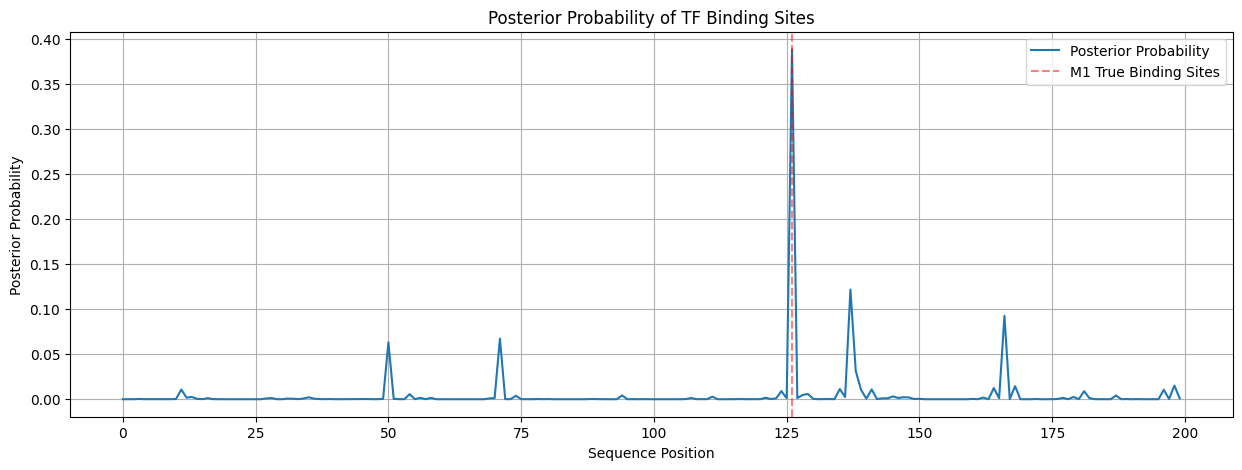

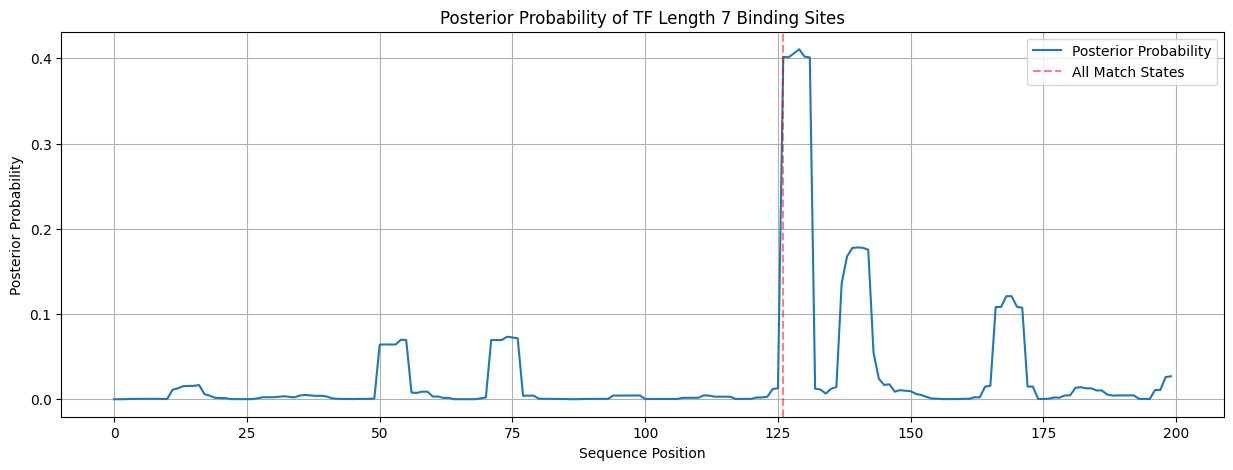

In [15]:
def forward_backward(sequence, T_m, E_m, dna_dict):
    seq_len = len(sequence)
    num_states = T_m.shape[0]
    
    # Forward and Backward size sequence length x number of states
    forward = np.zeros((seq_len, num_states))
    backward = np.zeros((seq_len, num_states))
    
    # Start in background state, playing forward through states sequences
    # NOTE: this is assumption, will fail if the TF is at position 0
    forward[0, 0] = 1.0
    
    # Simpler model should require only one match state and more cleverly iterate
    # Forward, could do log and just sum
    for i in range(1, seq_len):  
        for k in range(num_states): # outer state loop
            for l in range(num_states): # inner state loop -> find transition probabilities
                forward[i, k] += forward[i-1, l] * T_m[l, k]  # here alternatively we would iterate through the PWM
            forward[i, k] *= E_m[dna_dict[sequence[i]], k]
  
    # Initialize last column of backward matrix, evaluate all states
    backward[seq_len-1, :] = 1.0

    # Backward, possibility that we ended in any of the states
    for i in range(seq_len-2, -1, -1):
        for k in range(num_states):
            for l in range(num_states): # this time emissions are included in inner loop
                backward[i, k] += backward[i+1, l] * T_m[k, l] * E_m[dna_dict[sequence[i+1]], l]
    

    # Calculate posterior probabilities (gamma)
    posterior = forward * backward
    posterior = posterior / np.sum(posterior, axis=1, keepdims=True) # normalize to 1 for probabilities
    m1_posterior = posterior[:, 1] # match state 1 is beginning of TF binding site
    m_all_posterior = np.sum(posterior[:, 1:7], axis=1) # sum over match states to get full TF binding site
    
    return m1_posterior, forward, backward, m_all_posterior

# Calculate posterior probabilities
posterior_probs, forward, backward, all_match_posterior = forward_backward(random_sequence, T_m, E_m, dna_dict)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(posterior_probs)
plt.xlabel('Sequence Position')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability of TF Binding Sites')
plt.grid(True)
# Add vertical lines for true binding sites
for pos in tf_positions:
    plt.axvline(x=pos, color='r', linestyle='--', alpha=0.5)
plt.legend(['Posterior Probability', 'M1 True Binding Sites'])

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(all_match_posterior)
plt.xlabel('Sequence Position')
plt.ylabel('Posterior Probability')
plt.title(f'Posterior Probability of TF Length {tf_length} Binding Sites')
plt.grid(True)
# Add vertical lines for true binding sites
for pos in tf_positions:
    plt.axvline(x=pos, color='r', linestyle='--', alpha=0.5)

plt.legend(['Posterior Probability', 'All Match States'])

plt.show()

In [16]:
# Print the most likely binding site
# most_likely_binding_site = np.argmax(posterior_probs)  # for if returning the first match state
most_likely_binding_site = np.argwhere(posterior_probs >= np.max(posterior_probs)*0.99).reshape(-1)  # hacky and unclean
print(f"\nMost likely binding site position: {most_likely_binding_site[0]}")
# Print the most likely binding site sequence
most_likely_binding_site_seq = random_sequence[most_likely_binding_site[0]:most_likely_binding_site[0] + tf_length]
print(f"Most likely binding site sequence: {most_likely_binding_site_seq}")
# Print the real binding site location and sequence
for pos in tf_positions:
    print(f"Real binding site position: {pos}")
    print(f"Real binding site sequence: {random_sequence[pos:pos + tf_length]}")


Most likely binding site position: 126
Most likely binding site sequence: CAGGGGA
Real binding site position: 126
Real binding site sequence: CAGGGGA


#### Notes on Partition Function and Calculating Ratios of Sequence Likelihoods
For words $\alpha$ with probability to occur $\mathcal{p}_{\alpha}$, $\sum_{\alpha}\mathcal{p}_{\alpha}=1$, we maximize the likelihood of observing sequence $S$, defined with the partition function $Z$ of a sequence $$Z(S)=\sum_P\prod_{\alpha}(\mathcal{p}_{\alpha})^{N_{\alpha}(P)}$$Where $N_{\alpha}$ is the number of words, and $P$ is all possible segmentations of sequence $S$. The sum over all possible partitions of all sequences of length of $S$ $S'$ is about the same as the sum over all possible probabilities of words to the power of the number of words, $\sum_{S'}\simeq\left(\sum_{\alpha}\mathcal{p}_{alpha}\right)^{N_{av}}=1$. The average number of words can be given by $$\langle N_{\alpha}\rangle=\mathcal{p}_{\alpha}(\frac{\partial}{\partial \mathcal{p}_{\alpha}})=\frac{1}{Z}\sum_P\prod_{\alpha}N_{\alpha}(P)(\mathcal{p}_{\alpha})^{N_{\alpha}(P)}$$

With lagrange multiplier $\lambda$, the requirement $Z(S)-\lambda(\sum_{\alpha}\mathcal{p}_{\alpha}-1)$ is stationary w.r.t. $\lambda$ and $\mathcal{p}_{\alpha}$ for all $\alpha$, and $\mathcal{p}_{\alpha}=\frac{\langle N_{\alpha}\rangle}{\sum_{\beta}\langle N_{\beta}\langle}\equiv \mathcal{f}_{\alpha}$

With vector $p=(\mathcal{p}_{\alpha}|\alpha \in D)$, finding the vector $p$ that maximizes $Z$ is the same as finding the fixed point $p*$ of the nonlinear mapping $f(p)$ such that $f(p^*)=p^*$. How do we find this convergence? We iteratively find it as $f(p)+\frac{\partial f}{\partial p}\bigg\rvert _p(p^*-p)=p^*$

We can define $\frac{\partial f}{\partial p}$ in terms of Free Energy $F=-\text{log}Z$ and the relation to the average number of words $$\langle N_{\alpha}\rangle =-\mathcal{p}_{\alpha}(\frac{\partial}{\partial \mathcal{p_{\alpha}}})F $$. How solve for $F$? We define partition sum recursive relation $$Z(1,i)=\sum_{\mathcal{l}=1}^{\mathcal{l}_{\text{max}}}\mathcal{p}_{\sigma(i,\mathcal{l})}Z(1,i-\mathcal{l})$$, where $\sigma_{i,l}$ is the substring of length $l$ that ends at $i$ in $S$, and when $\alpha(i,l)\notin D$, $\mathcal{p}_{\alpha(i,l)}=0$.

We now define (forward) likelihood ratio $$R(i)=\frac{Z(1,i)}{Z(1, i-1)}=\mathcal{p}_{\alpha(i,1)}+\frac{\sum_{l=2}^{l=\text{max}}\mathcal{p}_{\alpha(i,l)}}{\prod_{k=i-l+1}^{i-1}R(k)}$$ and backward likelihood ratio $$R'(i)=\frac{Z(i,L)}{Z(i+1,L)}=\mathcal{p}_{\alpha(i+l-1,l)}+\frac{\sum_{l=2}^{l=\text{max}}\mathcal{p}_{\alpha(i+l-1,l)}}{\prod_{k=i+1}^{i+l-1}R'(k)}$$

Unlike the forward/backward probabilities, all $R(i)$ terms are of the same order.

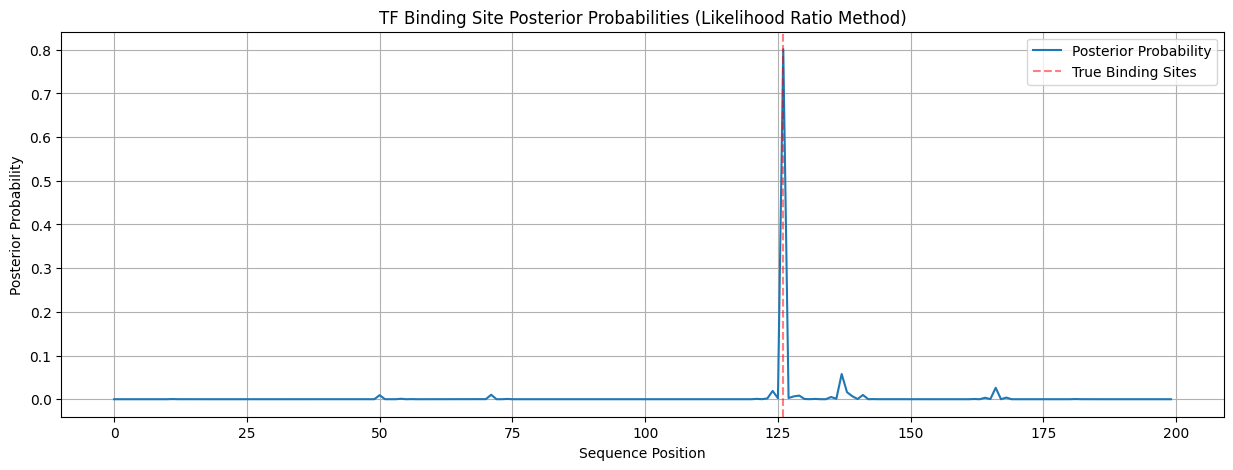

In [17]:
def calculate_likelihood_ratios(sequence, E_m, dna_dict, tf_length):
    # Note that this doesn't use the transition matrix
    seq_len = len(sequence)
    
    # Initialize forward and backward ratios
    R = np.zeros(seq_len)  # R(i) = Z(1,i)/Z(1,i-1)
    Rp = np.zeros(seq_len)  # R'(i) = Z(i,L)/Z(i+1,L)
    
    # Forward pass to calculate R
    # Initialize first position - Background state assumption again
    R[0] = E_m[dna_dict[sequence[0]], 0]  # probability of first nucleotide in background
    
    # Calculate forward ratios
    for i in range(1, seq_len):
        # Background contribution
        bg_contribution = E_m[dna_dict[sequence[i]], 0]
        
        # PWM contribution (if enough positions left)
        pwm_contribution = 0
        if i >= tf_length - 1:
            # Calculate probability of the segment being a binding site
            pwm_prob = 1.0
            for j in range(tf_length):
                pos = i - tf_length + j + 1
                pwm_prob *= E_m[dna_dict[sequence[pos]], j+1]
            
            # Divide by background probabilities of the previous positions
            for j in range(tf_length-1):
                pwm_prob /= R[i-tf_length+j+1]
            
            pwm_contribution = pwm_prob
            
        R[i] = bg_contribution + pwm_contribution
    
    # Backward pass to calculate R'
    # Initialize last position
    Rp[seq_len-1] = E_m[dna_dict[sequence[-1]], 0]
    
    # Calculate backward ratios
    for i in range(seq_len-2, -1, -1):
        # Background contribution
        bg_contribution = E_m[dna_dict[sequence[i]], 0]
        
        # PWM contribution (if enough positions left)
        pwm_contribution = 0
        if i <= seq_len - tf_length:
            # Calculate probability of the segment being a binding site
            pwm_prob = 1.0
            for j in range(tf_length):
                pwm_prob *= E_m[dna_dict[sequence[i+j]], j+1]
            
            # Divide by backward ratios of the following positions
            for j in range(1, tf_length):
                pwm_prob /= Rp[i+j]
                
            pwm_contribution = pwm_prob
            
        Rp[i] = bg_contribution + pwm_contribution
    
    # Calculate posterior probabilities
    posterior = np.zeros(seq_len)
    for i in range(seq_len - tf_length + 1):  # Stop when we can't go through the TF length
        pwm_prob = 1.0
        for j in range(tf_length):
            pwm_prob *= E_m[dna_dict[sequence[i+j]], j+1]  # product of forward emissions of match states every position
        
        # Normalize by forward and backward ratios
        if i > 0:
            for j in range(i):
                pwm_prob /= R[j]
        for j in range(i+tf_length, seq_len):
            pwm_prob /= Rp[j]
            
        posterior[i] = pwm_prob

    # Normalize posterior probabilities
    posterior = posterior / np.sum(posterior)
    
    return R, Rp, posterior

# Calculate likelihood ratios and posterior probabilities
R, Rp, posterior = calculate_likelihood_ratios(random_sequence, E_m, dna_dict, tf_length)

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(posterior)
plt.xlabel('Sequence Position')
plt.ylabel('Posterior Probability')
plt.title('TF Binding Site Posterior Probabilities (Likelihood Ratio Method)')
plt.grid(True)

# Add vertical lines for true binding sites
for pos in tf_positions:
    plt.axvline(x=pos, color='r', linestyle='--', alpha=0.5)
plt.legend(['Posterior Probability', 'True Binding Sites'])
plt.show()

#### Block 3 Inferring Transition and Emission Matrices
This section also does not follow the guideline (4 state HMM, Start, Random, BindingSite, End) but would require minimal editing as both transition and emission A and B are reinferred based on the above A B.
However this doesn't really work and I'm honestly not sure if the implementation is correct. 

Baum-Welch algorithm for reinferring the transition and emission matrices using Expectation Maximization and Bayes' Theorem. This starts by the: 

##### Expectation Step
Using the forward-backward algorithm to find likelihood of each state given the sequence: $$\alpha_i(t) = \sum_j \alpha_j(t-1) a_{ji} \theta_{i,x_t}, \quad \alpha_i(1) = \pi_i \theta_{i,x_1}$$ $$\beta_i(t) = \sum_j a_{ij} \theta_{j,x_{t+1}} \beta_j(t+1), \quad \beta_i(T) = 1$$ computes $\gamma=P(X_t=i|Y,\theta)$ (posterior of being in state $i$ at sequence position $t$ given observations $Y$ and HMM $\theta$), which at each nucleotide in the sequence $x_i$ is the probability of observing that nucleotide given the state and given the model, $$\gamma_i(t) = \frac{\alpha_i(t) \beta_i(t)}{\sum_j \alpha_j(t) \beta_j(t)}$$ Then we recompute the transition probabilities for all state transition pairs in the sequence, finding the expected number of transitions from state $i$ to $j$ is computed using the joint probability: $$\xi_{ij}(t) = \frac{\alpha_i(t) a_{ij} \theta_{j,x_{t+1}} \beta_j(t+1)}{\sum_{i,j} \alpha_i(t) a_{ij} \theta_{j,x_{t+1}} \beta_j(t+1)}$$


##### Maximization Step
We then update the Position Weight Matrix (part of our emission matrix) $\leftarrow$ (needs to change) using $$\theta_{k,x} = \frac{\sum_{t: x_t = x} \gamma_k(t)}{\sum_t \gamma_k(t)}$$ and for the emission matrix: $$a_{ij} = \frac{\sum_t \xi_{ij}(t)}{\sum_t \gamma_i(t)}$$

We'll start with 100 reps or the PWM converges.


In [18]:
def baum_welch(sequence, num_states, max_iterations=100, tolerance=1e-6):
    seq_len = len(sequence)
    
    # Initialize random transition matrix
    # Keep structure similar to original but with random probabilities
    A = np.zeros((num_states, num_states))
    A[0,0] = 0.9  # High probability to stay in background
    A[0,1] = 0.1  # Low probability to transition to motif
    # Force transitions through motif states
    for i in range(1, num_states-1):
        A[i, i+1] = 1.0
    A[-1,0] = 1.0  # Return to background after motif
    
    # Initialize random emission matrix
    B = np.random.rand(4, num_states)
    # Make background emissions roughly uniform
    B[:,0] = np.array([0.25, 0.25, 0.25, 0.25])
    # Normalize other columns
    B = B / B.sum(axis=0)
    
    for _ in range(max_iterations):
        # deep copy to check convergence
        old_A = A.copy()
        old_B = B.copy()
        
        # Forward-Backward
        forward = np.zeros((seq_len, num_states))
        backward = np.zeros((seq_len, num_states))
        
        # Initialize forward
        forward[0,0] = 1.0
        
        # Forward pass
        for t in range(1, seq_len):
            for j in range(num_states):
                for i in range(num_states):
                    forward[t,j] += forward[t-1,i] * A[i,j]
                forward[t,j] *= B[dna_dict[sequence[t]], j]
        
        # Initialize backward
        backward[seq_len-1,:] = 1.0
        
        # Backward pass
        for t in range(seq_len-2, -1, -1):
            for i in range(num_states):
                for j in range(num_states):
                    backward[t,i] += backward[t+1,j] * A[i,j] * B[dna_dict[sequence[t+1]], j]
        
        # Update parameters
        # Compute xi (transition) and gamma (emission) probabilities
        xi = np.zeros((seq_len-1, num_states, num_states))
        gamma = np.zeros((seq_len, num_states))
        
        # Calculate gamma
        for t in range(seq_len):
            gamma[t] = forward[t] * backward[t]
            gamma[t] /= gamma[t].sum()
        
        # Calculate xi
        for t in range(seq_len-1):
            for i in range(num_states):
                for j in range(num_states):
                    xi[t,i,j] = forward[t,i] * A[i,j] * B[dna_dict[sequence[t+1]], j] * backward[t+1,j]
            xi[t] /= xi[t].sum()
        
        # Update transition matrix A
        for i in range(num_states):
            for j in range(num_states):
                numerator = xi[:,i,j].sum()
                denominator = gamma[:-1,i].sum()
                if denominator > 0:
                    A[i,j] = numerator / denominator
        
        # Update emission matrix B
        for k in range(4):  # For each nucleotide
            for j in range(num_states):
                numerator = sum(gamma[t,j] for t in range(seq_len) if sequence[t] == dna_letters[k])
                denominator = gamma[:,j].sum()
                if denominator > 0:
                    B[k,j] = numerator / denominator
        
        # Check convergence
        if (np.abs(A - old_A).max() < tolerance and 
            np.abs(B - old_B).max() < tolerance):
            break
    
    return A, B


In [ ]:
# Run Baum-Welch algorithm
inferred_T, inferred_E = baum_welch(random_sequence, T_m.shape[0])

# Print results
jupyprint("\nOriginal Transition Matrix:")
jupyprint(arraytex(T_m))
jupyprint("\nInferred Transition Matrix:")
jupyprint(arraytex(inferred_T))
jupyprint("\nOriginal Emission Matrix:")
jupyprint(arraytex(E_m))
jupyprint("\nInferred Emission Matrix:")
jupyprint(arraytex(inferred_E))


Original Transition Matrix:

\begin{bmatrix}{} 0.995 & 0.005 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 \\ 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}


Inferred Transition Matrix:

\begin{bmatrix}{} 0.9038653841624235 & 0.09613461583757651 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0000000000000002 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.9999999999999999 \\ 1.0000000000000002 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}


Original Emission Matrix:

\begin{bmatrix}{} 0.25 & 0.05000675188975273 & 0.5453575571769426 & 0.05583940728482751 & 0.3623074223374083 & 0.050043142765806195 & 0.05000000937714809 & 0.14469791118225725 \\ 0.25 & 0.5479886867335553 & 0.05000001810972187 & 0.05851826446364811 & 0.05529613248024754 & 0.33119644820727634 & 0.05002646289458974 & 0.05000000000311761 \\ 0.25 & 0.352004561376692 & 0.3500000000176797 & 0.8356423276549675 & 0.5049717190865414 & 0.5019597386195157 & 0.8499657472473058 & 0.7309978822536712 \\ 0.25 & 0.05 & 0.054642424695655806 & 0.05000000059655687 & 0.07742472609580274 & 0.11680067040740189 & 0.05000778048095642 & 0.07430420656095392 \\ \end{bmatrix}


Inferred Emission Matrix:

\begin{bmatrix}{} 0.276472841582434 & 6.769674775252479e-100 & 3.64112830270798e-59 & 0.1771135898931985 & 0.09100162100786588 & 0.638131860073904 & 0.47861767578285186 & 9.309074216786316e-44 \\ 0.40767811515239855 & 0.21750841326738207 & 8.561126421646751e-15 & 0.07680342321325791 & 6.04967442854598e-22 & 6.775203358962085e-48 & 0.16610217491799545 & 0.24775046385119037 \\ 0.1622359803578764 & 0.17667978105078078 & 0.9999999999999915 & 0.4190476910447319 & 0.5526949677391534 & 4.988017943534404e-31 & 0.1826266781530297 & 0.2521063840291113 \\ 0.15361306290729096 & 0.6058118056818371 & 1.3796509704452937e-18 & 0.32703529584881164 & 0.356303411252981 & 0.36186813992609596 & 0.17265347114612298 & 0.5001431521196984 \\ \end{bmatrix}

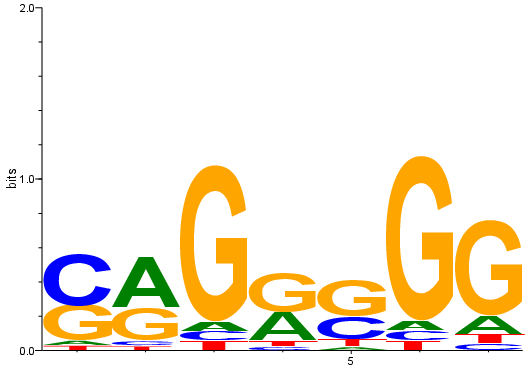

In [20]:
# Plot sequence logos for comparison - Original
seqlogo.seqlogo(seqlogo.Ppm(E_m[:,1:].T), font_size=30, ic_scale=True, format='png')

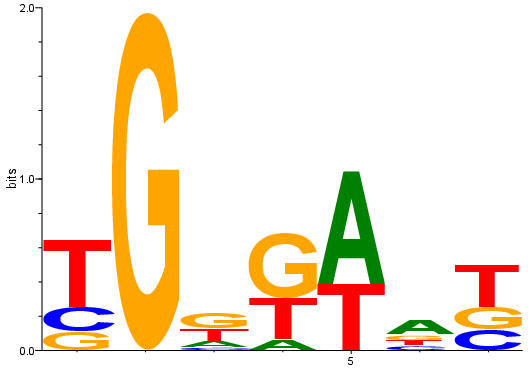

In [21]:
# Inferred PWM
seqlogo.seqlogo(seqlogo.Ppm(inferred_E[:,1:].T), font_size=30, ic_scale=True, format='png')

In [22]:
# Print most likely sequence from pwm
pwm_orig = np.array(E_m[:,1:])
most_probable_tf_binding_site_original = ''.join([dna_letters[np.argmax(pwm_orig[:,i])] for i in range(tf_length)])
most_probable_tf_probability_original = calculate_sequence_probability(pwm_orig, [most_probable_tf_binding_site_original], dna_letters)
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site_original} with probability {list(most_probable_tf_probability_original)[0][1]:0.4f}")

pwm_inferred = np.array(inferred_E[:,1:])
most_probable_tf_binding_site_inferred = ''.join([dna_letters[np.argmax(pwm_inferred[:,i])] for i in range(tf_length)])
most_probable_tf_probability_inferred = calculate_sequence_probability(pwm_inferred, [most_probable_tf_binding_site_inferred], dna_letters)
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site_inferred} with probability {list(most_probable_tf_probability_inferred)[0][1]:0.4f}")



Most probable TF binding site sequence: CAGGGGG with probability 0.0393

Most probable TF binding site sequence: TGGGAAT with probability 0.0214
